# Modeling the energy production and consumption

In [582]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, Input

import tensorflow as tf
tf.keras.utils.set_random_seed(1234)

In [583]:
df = pd.read_csv("data_clean.csv")

In [584]:
df

,is_consumption,eic_count,installed_capacity,day,weekday,month,year,sin(dayofyear),cos(dayofyear),sin(hour),...,snowfall_fl,total_precipitation_fl,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target
0,0,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.000000,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.000000,...,0.0,0.0,139.453,58.607,52.032,146.872,126.820,125.237,115.243,137.370
2,0,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.258819,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.258819,...,0.0,0.0,170.381,59.506,45.385,143.722,127.469,119.205,125.407,131.906
4,0,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.500000,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29883,1,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.707107,...,0.0,0.0,136.592,65.207,63.559,153.743,129.940,113.642,126.078,132.470
29884,0,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.500000,...,0.0,0.0,0.000,0.005,0.002,0.005,0.004,0.003,0.000,0.002
29885,1,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.500000,...,0.0,0.0,121.699,75.828,69.059,117.201,113.768,93.736,123.870,114.667
29886,0,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.258819,...,0.0,0.0,0.002,0.002,0.005,0.003,0.000,0.004,0.000,0.000


In [585]:
df.columns

Index(['is_consumption', 'eic_count', 'installed_capacity', 'day', 'weekday',
       'month', 'year', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)',
       'cos(hour)', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'temperature_fl', 'dewpoint_fl',
       'cloudcover_high_fl', 'cloudcover_low_fl', 'cloudcover_mid_fl',
       'cloudcover_total_fl', '10_metre_u_wind_component_fl',
       '10_metre_v_wind_component_fl', 'direct_solar_radiation_fl',
       'surface_solar_radiation_downwards_fl', 'snowfall_fl',
       'total_precipitation_fl', 'target_1', 'target_2', 'target_3',
       'target_4', 'target_5', 'target_6', 'target_7', 'target'],
      dtype='object')

In [586]:
features = [
    'installed_capacity',
    
    # weaher
    'temperature',
    'dewpoint',
    'cloudcover_high',
    'cloudcover_low',
    'cloudcover_mid',
    'cloudcover_total',
    '10_metre_u_wind_component',
    '10_metre_v_wind_component',
    'direct_solar_radiation',
    'surface_solar_radiation_downwards',
    'snowfall',
    'total_precipitation',
    
    # forecast
    'temperature_fl',
    'dewpoint_fl',
    'cloudcover_high_fl',
    'cloudcover_low_fl',
    'cloudcover_mid_fl',
    'cloudcover_total_fl',
    '10_metre_u_wind_component_fl',
    '10_metre_v_wind_component_fl',
    'direct_solar_radiation_fl',
    'surface_solar_radiation_downwards_fl',
    'snowfall_fl',
    'total_precipitation_fl',

    # datetime
    'day', 
    'weekday',
    'month', 
    'year', 
    'sin(dayofyear)', 
    'cos(dayofyear)', 
    'sin(hour)',
    'cos(hour)',

    # lags of enerygy production
    'target_1',
    'target_2',
    'target_3',
    'target_4',
    'target_5',
    'target_6',
    'target_7'
]

### Energy production modeling

In [587]:
df_production = df.loc[df.is_consumption==0].drop(columns="is_consumption").reset_index(drop=True)

In [588]:
df_production

,eic_count,installed_capacity,day,weekday,month,year,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),...,snowfall_fl,total_precipitation_fl,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target
0,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.000000,1.000000,...,0.0,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.258819,0.965926,...,0.0,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.500000,0.866025,...,0.0,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.707107,0.707107,...,0.0,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,6.0,324.2,15,3,9,2021,-0.960150,-0.279486,0.866025,0.500000,...,0.0,8.940697e-08,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14939,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.965926,0.258819,...,0.0,0.000000e+00,10.605,14.375,25.598,9.822,7.201,7.283,10.316,9.685
14940,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.866025,0.500000,...,0.0,0.000000e+00,4.253,7.447,7.501,2.767,3.239,1.926,3.897,3.365
14941,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.707107,0.707107,...,0.0,0.000000e+00,0.187,0.859,1.011,0.396,0.061,0.113,0.170,0.379
14942,17.0,540.0,31,3,5,2023,0.522133,-0.852864,-0.500000,0.866025,...,0.0,0.000000e+00,0.000,0.005,0.002,0.005,0.004,0.003,0.000,0.002


In [589]:
def split__train_val_test_sets(df):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)
    
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.target.values
    y_val = df_val.target.values
    y_test = df_test.target.values
    
    del df_train['target']
    del df_val['target']
    del df_test['target']
    return df_train, df_test, df_val, y_train, y_test, y_val

In [590]:
df_train, df_test, df_val, y_train, y_test, y_val = split__train_val_test_sets(df_production)

In [591]:
df_train

,eic_count,installed_capacity,day,weekday,month,year,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),...,surface_solar_radiation_downwards_fl,snowfall_fl,total_precipitation_fl,target_1,target_2,target_3,target_4,target_5,target_6,target_7
0,18.0,645.2,27,2,12,2022,-0.085731,0.996318,-5.000000e-01,-0.866025,...,26.905348,0.000000,2.187490e-05,0.878,2.871,0.268,0.040,0.042,0.010,0.000
1,6.0,324.2,23,7,1,2022,0.384665,0.923056,7.071068e-01,0.707107,...,0.000000,0.000000,0.000000e+00,0.000,0.000,0.000,0.000,0.004,0.001,0.000
2,15.0,505.2,14,5,10,2022,-0.977064,0.212947,-7.071068e-01,0.707107,...,0.000000,0.000000,2.933741e-04,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,18.0,645.2,30,3,11,2022,-0.522133,0.852864,-5.000000e-01,0.866025,...,0.000000,0.000002,-1.830631e-08,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,16.0,572.2,7,5,4,2023,0.995546,-0.094279,-5.000000e-01,-0.866025,...,584.159200,0.000000,0.000000e+00,3.897,45.460,46.464,82.348,99.091,14.645,8.082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,6.0,330.2,17,2,5,2022,0.710135,-0.704066,-8.660254e-01,-0.500000,...,339.671100,0.000000,5.960465e-07,53.507,6.028,40.570,7.489,40.749,36.090,34.097
8962,15.0,505.2,19,3,10,2022,-0.955211,0.295927,9.659258e-01,-0.258819,...,0.000000,0.000000,0.000000e+00,0.000,0.000,0.000,0.001,0.000,0.003,0.001
8963,6.0,324.2,8,2,2,2022,0.620609,0.784120,1.224647e-16,-1.000000,...,157.455550,0.000010,1.368353e-05,0.575,0.623,0.036,0.116,0.280,0.089,10.318
8964,16.0,569.7,30,4,3,2023,0.999079,0.042905,9.659258e-01,0.258819,...,0.000000,0.000012,8.165836e-06,0.005,0.006,0.007,0.004,0.006,0.006,0.004


In [592]:
X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

In [593]:
scaler = StandardScaler()
scaler.fit(X_train)
print(scaler.mean_)

[4.68307707e+02 5.55454437e+00 2.22415662e+00 3.94162010e-01
 4.33270385e-01 3.58108784e-01 6.80982845e-01 1.13611528e+00
 7.32562933e-01 1.49169505e+02 1.08997982e+02 2.63616824e-05
 8.03756845e-05 5.61623975e+00 2.04651246e+00 3.97875007e-01
 4.21758251e-01 3.45672100e-01 6.72226674e-01 7.75882042e-01
 6.04910210e-01 1.51848428e+02 1.09429850e+02 2.37022894e-05
 7.93497275e-05 1.58914789e+01 3.96988624e+00 6.40932411e+00
 2.02206737e+03 4.82427096e-02 1.35266690e-01 1.47651255e-03
 7.65782531e-03 9.96768938e+00 9.68639616e+00 9.54436861e+00
 9.53862670e+00 9.36637910e+00 9.45271838e+00 9.11415113e+00]


In [594]:
X_train_scaled = scaler.transform(X_train)

### Neural Network

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [595]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

n_features = len(features)

model = get_model(X_train_scaled.shape[1], 1)

In [596]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 64)                2624      
                                                                 
 dense_64 (Dense)            (None, 32)                2080      
                                                                 
 dense_65 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [597]:
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=1024,
    epochs=8,
#     validation_data=(X_train_scaled, y_train)
)

Epoch 1/8
9/9 [==============================] - 1s 3ms/step - loss: 672.6611 - mse: 672.6611
Epoch 2/8
9/9 [==============================] - 0s 3ms/step - loss: 605.8356 - mse: 605.8356
Epoch 3/8
9/9 [==============================] - 0s 4ms/step - loss: 533.7268 - mse: 533.7268
Epoch 4/8
9/9 [==============================] - 0s 3ms/step - loss: 451.7012 - mse: 451.7012
Epoch 5/8
9/9 [==============================] - 0s 3ms/step - loss: 363.3288 - mse: 363.3288
Epoch 6/8
9/9 [==============================] - 0s 3ms/step - loss: 276.3861 - mse: 276.3861
Epoch 7/8
9/9 [==============================] - 0s 3ms/step - loss: 205.4520 - mse: 205.4520
Epoch 8/8
9/9 [==============================] - 0s 3ms/step - loss: 164.5599 - mse: 164.5599


### Test

In [598]:
X_test_scaled = scaler.transform(X_test)

In [599]:
predictions = model.predict(X_test_scaled)

94/94 [==============================] - 0s 1ms/step


In [600]:
def add_predictions(df,predictions):
    df["prediction"] = predictions
    return df

In [601]:
predictions

array([[ 0.        ],
       [54.39227   ],
       [25.748772  ],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.73134464]], dtype=float32)

In [602]:
y_pred = predictions.reshape(-1)

In [603]:
rng = np.random.RandomState(10)
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))

In [604]:
a

array([ 1.3315865 ,  0.71527897, -1.54540029, ...,  5.74446677,
        6.22449239,  8.42055014])

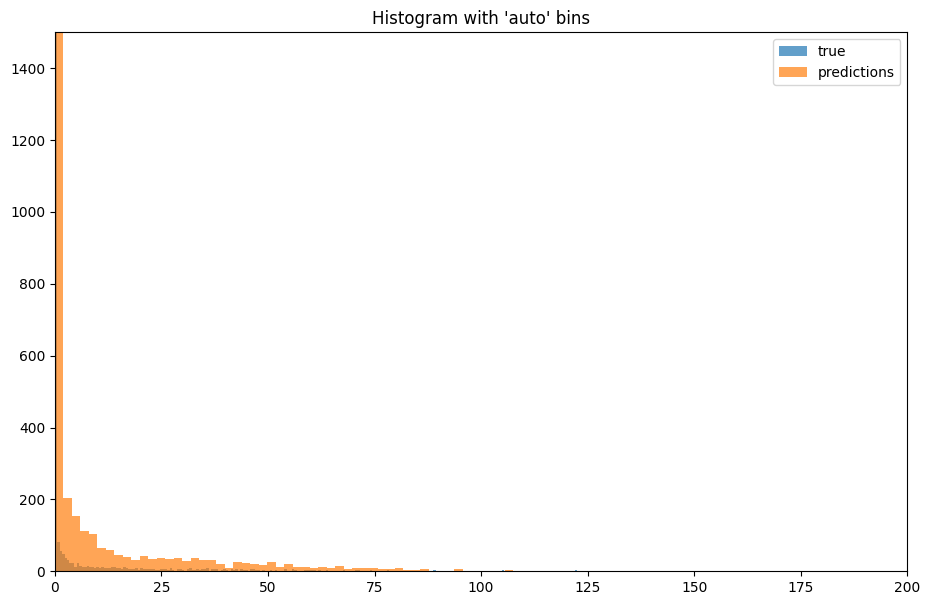

In [610]:
plt.figure(figsize=(11,7))
_ = plt.hist(y_test, bins='auto', alpha=0.7, label="true")  # arguments are passed to np.histogram
_ = plt.hist(y_pred, bins='auto', alpha=0.7, label="predictions")  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
# plt.show()
plt.title("Histogram with 'auto' bins")
plt.xlim([0, 200])
plt.ylim([0, 1500])
plt.legend()
plt.show()

In [606]:
y_pred.max()

113.57516

In [607]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred, y_test)
mse

164.2508896967208

In [608]:
y_test.mean()

10.297117096018734

In [609]:
y_pred.mean()

11.801172